In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import xarray as xa
import scipy.stats as stats
from scipy.special import loggamma
from statsmodels.sandbox.distributions.mv_normal import MVT
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import wraps
from cycler import cycler
from itertools import cycle
# from fastcache import lru_cache
import inspect
import gsum
from gsum import rbf, default_attributes, cholesky_errors, mahalanobis, lazy_property, pivoted_cholesky
from gsum import ConjugateGaussianProcess, ConjugateStudentProcess, Diagnostic, GraphicalDiagnostic

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

%load_ext Cython
%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 120

In [3]:
nn = 10
a = np.random.randn(nn, nn)
aa = a.T @ a + np.eye(nn)
y = np.random.randn(nn)
mean = np.ones(nn)
chol_aa = np.linalg.cholesky(aa)
pinv_aa = np.linalg.pinv(aa)
chol_md = mahalanobis(y, mean, chol=chol_aa)
pinv_md = mahalanobis(y, mean, inv=pinv_aa)
print(np.allclose(pinv_md, chol_md))
print(pinv_md, chol_md)

True
1.5887598159868566 1.5887598159868568


# B&O Model Checking Implementation

Bastos & O'Hagan provided a great set of diagnostic tools for testing whether or not a Gaussian process (GP) is a reasonable emulator for an expensive simulator. Our use case is slightly different than theirs. We don't necessarily care about our GPs matching some underlying simulator. Rather, given a set of curves from a hierarchy of simulators, we wish to answer the following questions:
1. Can they reasonably be assumed to be drawn from the same underlying Gaussian process?
2. If so, which Gaussian process?
3. The underlying GP is later used as a model discrepancy, so how can we test its performance against experiment?

These three questions may or may not be decided by diagnostics discussed in B&O, but to find out we must implement their methods!
That is what this notebook aims to do.

## Model Checking for GPs (Source Code)


Python has no pivoted cholesky decomposition, so I made one myself from `gsl`.
Prove that the pivoted cholesky I wrote works:

In [4]:
np.random.seed(1)
# m = np.ones((4, 4)) + 2 * np.eye(4)
r = np.random.rand(4, 4)
m = r + r.T + 2 * np.eye(4)
G_pc = pivoted_cholesky(m)

# print('R\n', pc, '\n\nP\n', pp, '\n')
# G = pp @ pc
print('M original\n', m, '\n')
print('G\n', G_pc, '\n')
# print(G @ G.T)
print('G.G^T = M?', np.allclose(G_pc @ G_pc.T, m))

M original
 [[2.83404401 0.86708038 0.39688185 0.50678482]
 [0.86708038 2.18467719 0.72507695 1.22367816]
 [0.39688185 0.72507695 2.83838903 0.71260709]
 [0.50678482 1.22367816 0.71260709 3.34093502]] 

G
 [[0.27726151 1.66047284 0.         0.        ]
 [0.6694732  0.41040191 0.24095152 1.22881873]
 [0.38986669 0.17391843 1.6297685  0.        ]
 [1.82782248 0.         0.         0.        ]] 

G.G^T = M? True


Here I am just testing two different equations for the posterior scale parameter. Ignore unless you're into that sort of thing.

In [5]:
def scale_test(y, R, m0=0, v0=1, a0=1, b0=1):
    y = np.atleast_2d(y)
    N = y.shape[-1]
    ny = y.shape[0]
    print(ny, N)
    avg_y = np.average(y, axis=0)
    one = np.ones(N, dtype=np.float64)
    cholR = np.linalg.cholesky(R)
    
    a = a0 + N*ny / 2.
    v = (1./v0 + ny * mahalanobis(one, 0., cholR)**2)**(-1)
    m = v * (m0 / v0 + ny * one @ np.linalg.solve(R, avg_y))
    b = b0 + 0.5 * (m0**2 / v0 - m**2 / v + np.sum(mahalanobis(y, 0, cholR)**2))
    
    R2 = R / ny + one * v0 * one[:, None]
    chol2 = np.linalg.cholesky(R2)
    b_test = b0 + 0.5 * (mahalanobis(avg_y, m0, chol2)**2 + np.sum(mahalanobis(y, avg_y, cholR)**2))
    return b, b_test, np.allclose(b_test, b)

np.random.seed(20)
N = 5
xx = np.linspace(0, 5, N)
y = np.random.rand(5, N)
RR = rbf(xx[:, None])
# RR = np.eye(N)
bb, bb_test, isEqual = scale_test(y, RR, v0=1)
bb, bb_test, isEqual

5 5


(2.452307469272622, 2.4523074692726228, True)

## The Model

Begin by drawing a set of curves from a GP, then pick a set of points to fit to. Below are the parameters one might want to adjust:

In [6]:
X_full = np.atleast_2d(np.linspace(0, 20, 41)).T
mask = np.array([i % 3 == 0 for i in range(len(X_full))])

n_samples = 4
n_ref = 1000
nugget_sd = 2e-4
sd_true = 1.0
ls_true = 3

true_kernel = C(sd_true, (1e-3, 1e3)) * RBF(ls_true, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel
orders = np.arange(n_samples)
ratio = 0.5  # Expansion parameter

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

Given the above parameters, we can start by sampling curves and masking down to a reasonable training set.

## Breaking by variance shift: middle-sized shift
Now we make the variance shift smaller and see what happens

In [7]:
basevariance=1.0; varianceshiftfactor=3; baselengthscale=3; lengthscaleshift=0

In [8]:
true_kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvarup_kernel=C(basevariance*varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvardown_kernel=C(basevariance/varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthup_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale+lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthdown_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale-lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

gp1 = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None,)
gp2 = GaussianProcessRegressor(kernel=shiftvarup_kernel,n_restarts_optimizer=9, optimizer=None)
gp3 = GaussianProcessRegressor(kernel=shiftvardown_kernel,n_restarts_optimizer=9, optimizer=None)

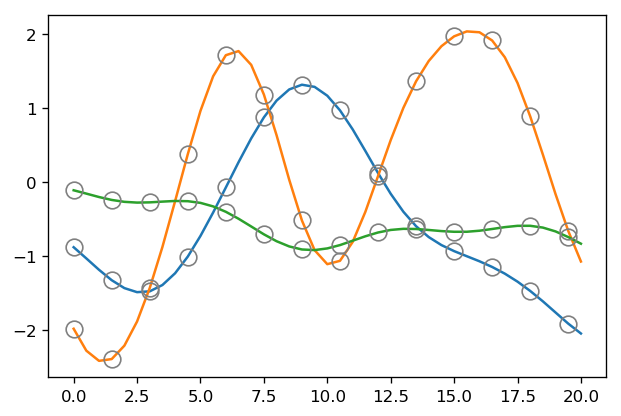

In [9]:
# Instantiate a Gaussian Process model

# gp.fit()
#toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
#mean_full, cov_full = gp.predict(X_full, return_cov=True)
#The above three lines of code get replaced by something a bit more complicated when we have different GPs that we want to lump together as if they were one.
#Note that we gave up returning the covariances of the GP for which we generate the data since we decided we should not be using them.
seed=5; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T
#Note also that I (DP) have switched the seed after each call, to try and get GPs that start at somewhat different points. This may be unnecessary? But I hope
#it is at least not wrong. :) 


mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

#mean = mean_full[mask]
#cov = cov_full[mask][:, mask]
#I comment out these two lines since I do not think we should be using these quantities: the code should interact with the underlying GP
#only through the toy_data, which we now generate.

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

toy_data = toy_data_full[:, mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Remember: blue curve is the original variance (1), orange has a larger variance, and green a smaller one. 

Once again, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

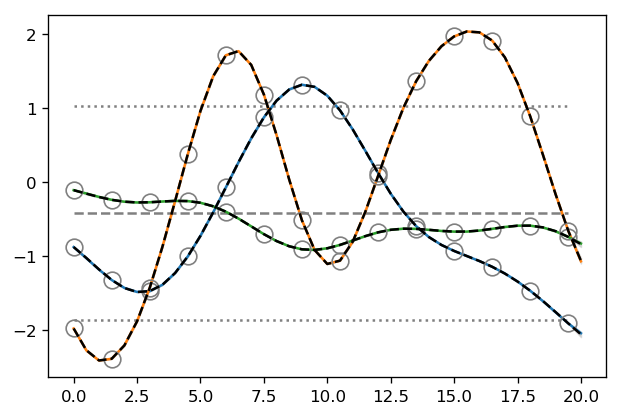

In [10]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
toy_data_test = toy_data_full[:, ~mask]

#compute the mean and covariance of the fitted GP at the training-set points
fitmean = my_gp.mean()
fitcov = my_gp.cov()

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances
X_new = X_full
X_test = X_full[~mask]
# my_gp.beta()
m_pred, K_pred = my_gp.predict(X_new, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

#compute the mean and covaraince of the overall GP at the set X_full, note that a nugget should be added to fitcov_full when it is used below.
fitmean_full = my_gp.mean(X_new) 
fitcov_full = my_gp.cov(X_new,X_new) 
fitmean_test = my_gp.mean(X_test)
fitcov_test = my_gp.cov(X_test,X_test)

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_new.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_new.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

This time the standard deviation still comes out a bit larger than one. Postpone model checking until after length-scale estimation. 

## Learning the length scale: medium-variance-shift case

Now we will do the length-scale learning for this medium-variance-shift case

In [11]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)

Setting kernel kwargs to {'ls': 2.957575757575758}


This time the length scale comes about a little bit, but not disturbingly, low. 

How will the diagnostics look?

Setting kernel kwargs to {'ls': 2.957575757575758}


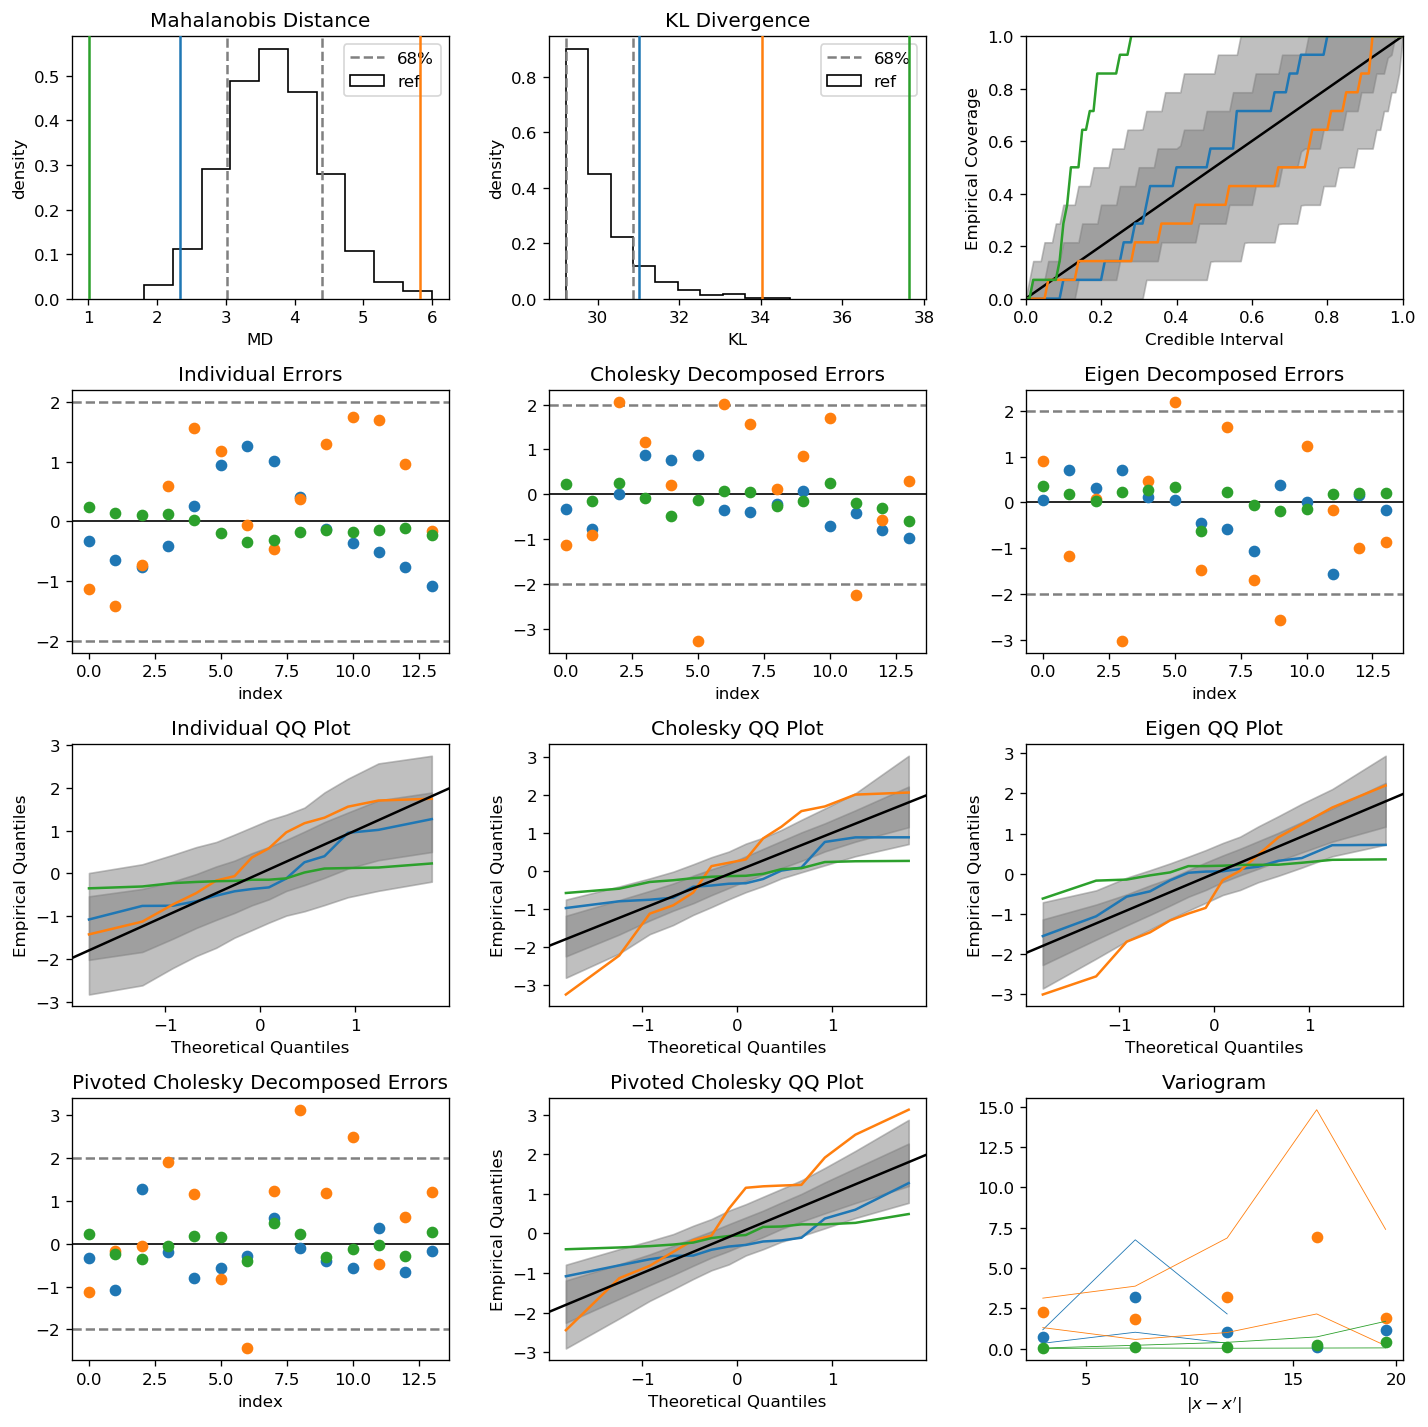

In [12]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()
fitmean_test = gp.mean(X_test) 
fitcov_test = gp.cov(X_test,X_test) 

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

There are too many green errors that are too small and too many orange errors that are too big. This shows up in the Mahalanobis distances.

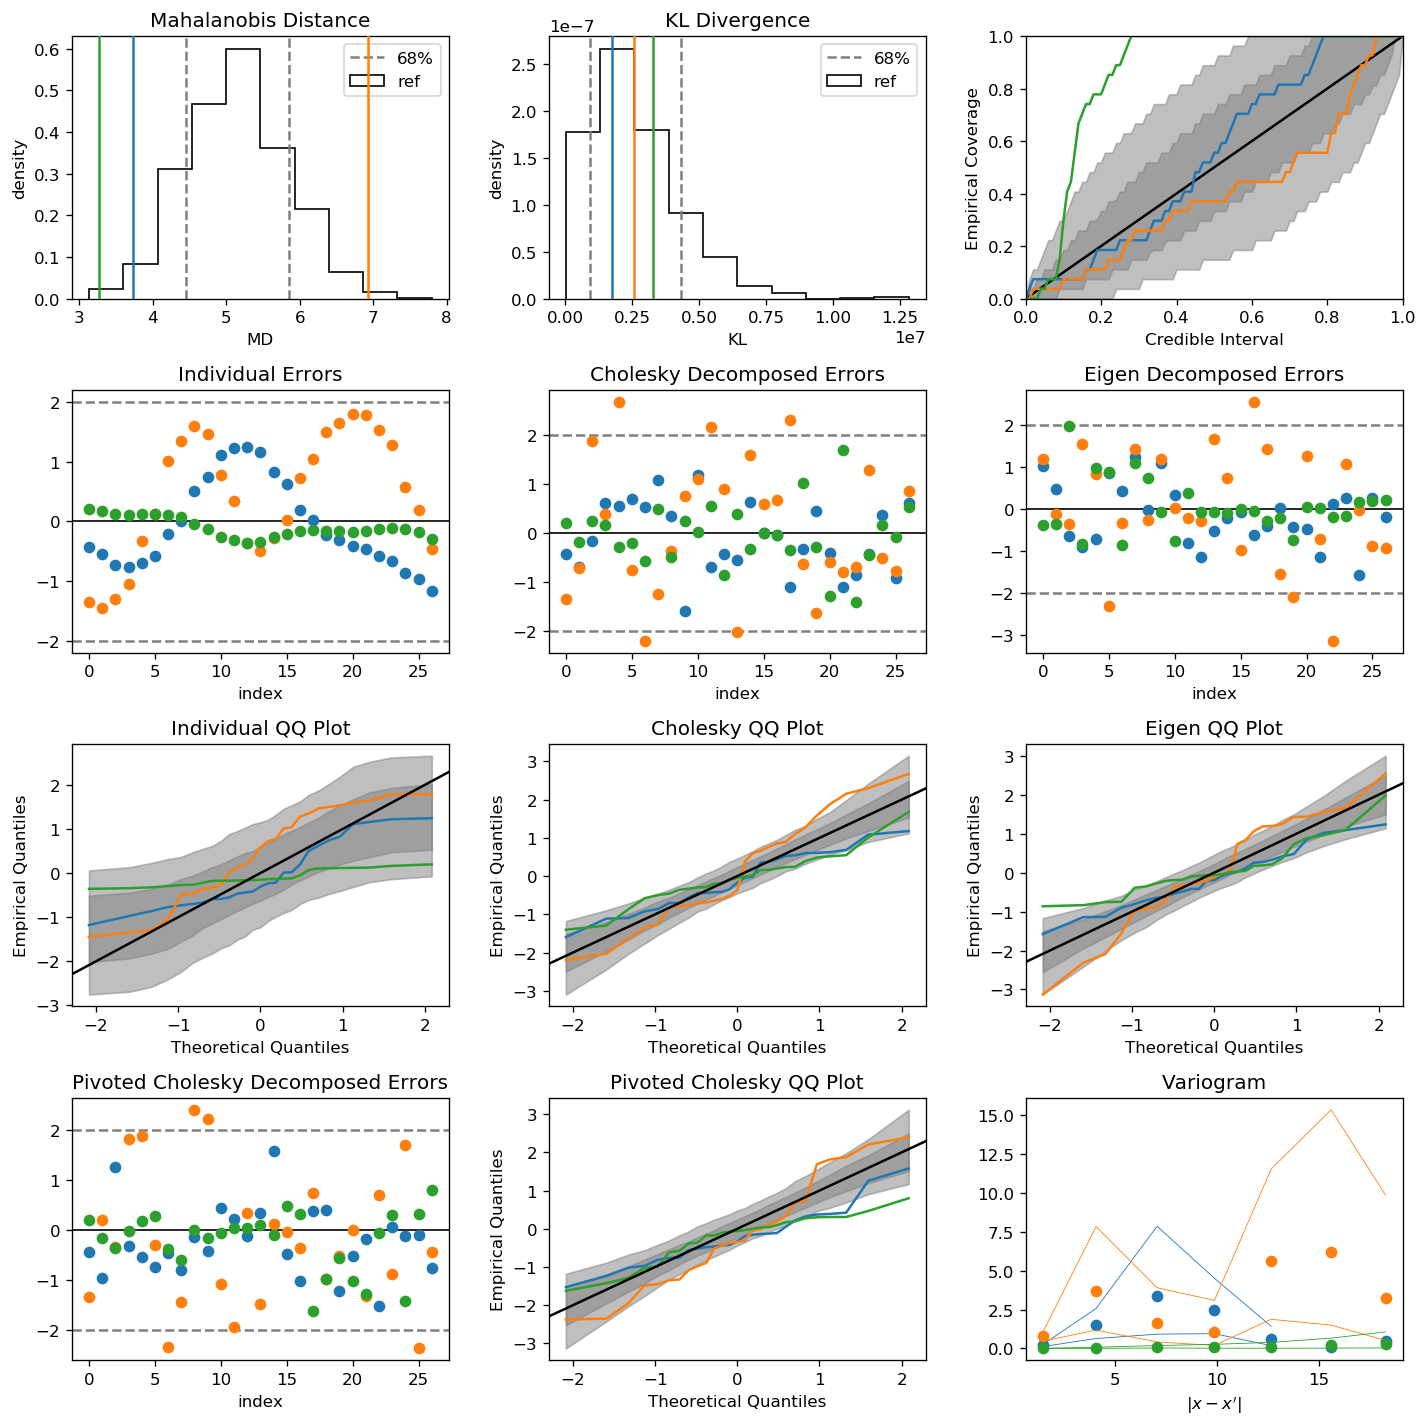

In [13]:
gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd_test = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd_test.plotzilla(X_test, gp_static, vlines=vlines);

DCI plot for green reveals problems. Problems with variance show up at low index in PC decomposed errors and high index in eigen decomposed errors for green & (maybe?) orange. Blue looks fine there.

What about the interpolants?

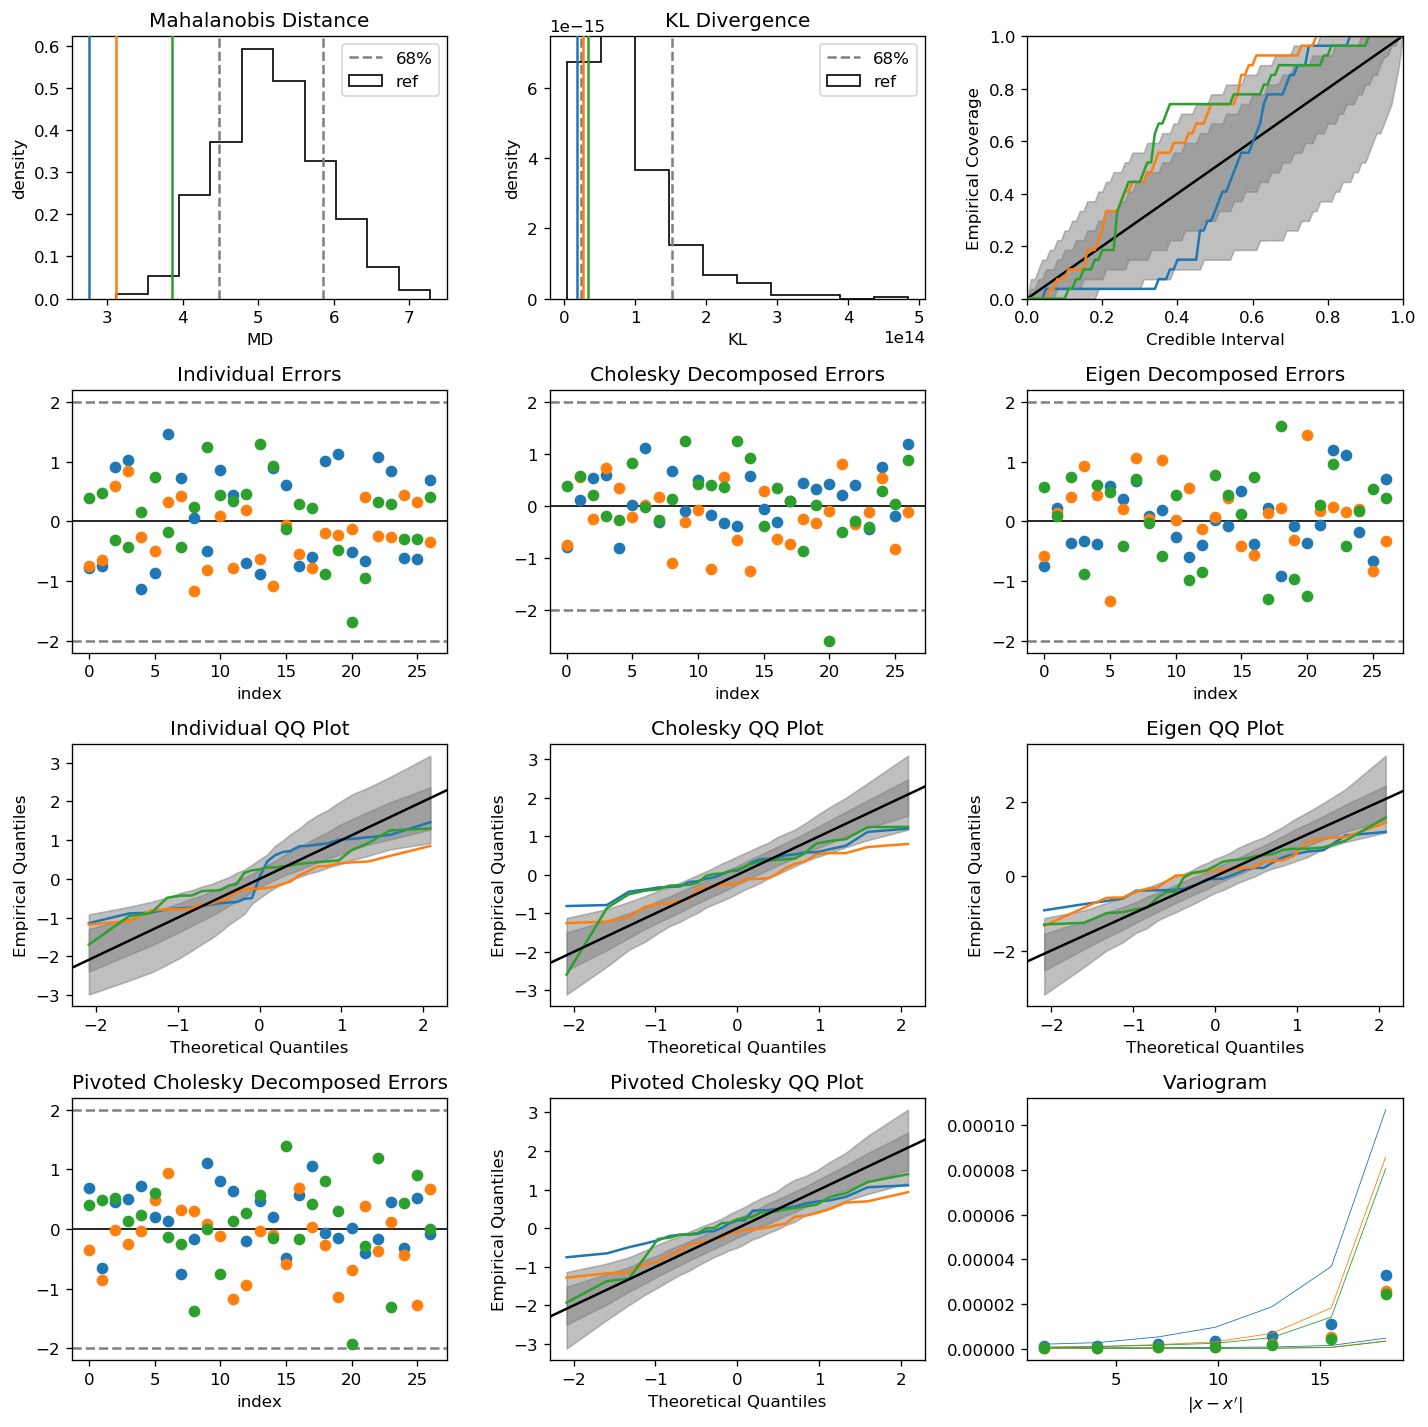

In [14]:
#gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)

gpmc = Diagnostic(np.zeros(mean_test.shape[1]), cov_test + nugget_sd**2 * np.eye(cov_test.shape[0]))
gd = GraphicalDiagnostic(gpmc, toy_data_test-mean_test, nref=n_ref)
gd.plotzilla(X_test, gp_static, vlines=vlines);

The interpolants seem to work too well for everything.

## Middle-sized variance shift, different noise
Now we try with a different seed, to see what changes and what doesn't

In [15]:
basevariance=1.0; varianceshiftfactor=3; baselengthscale=3; lengthscaleshift=0

In [16]:
true_kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvarup_kernel=C(basevariance*varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvardown_kernel=C(basevariance/varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthup_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale+lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthdown_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale-lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

gp1 = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None,)
gp2 = GaussianProcessRegressor(kernel=shiftvarup_kernel,n_restarts_optimizer=9, optimizer=None)
gp3 = GaussianProcessRegressor(kernel=shiftvardown_kernel,n_restarts_optimizer=9, optimizer=None)

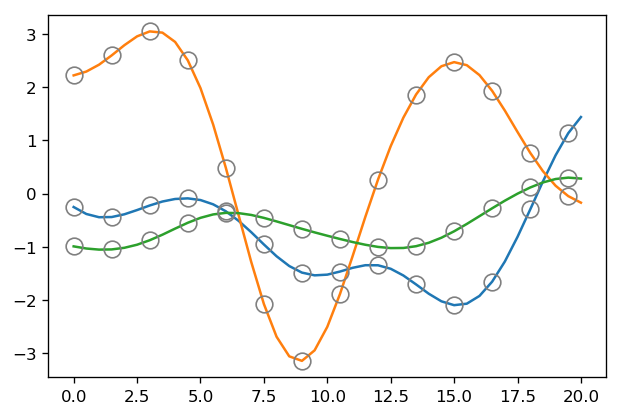

In [17]:
# Instantiate a Gaussian Process model

# gp.fit()
#toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
#mean_full, cov_full = gp.predict(X_full, return_cov=True)
#The above three lines of code get replaced by something a bit more complicated when we have different GPs that we want to lump together as if they were one.
#Note that we gave up returning the covariances of the GP for which we generate the data since we decided we should not be using them.
seed=1; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T
#Note also that I (DP) have switched the seed after each call, to try and get GPs that start at somewhat different points. This may be unnecessary? But I hope
#it is at least not wrong. :) 


mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

#mean = mean_full[mask]
#cov = cov_full[mask][:, mask]
#I comment out these two lines since I do not think we should be using these quantities: the code should interact with the underlying GP
#only through the toy_data, which we now generate.

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

toy_data = toy_data_full[:, mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Remember: blue curve is the original variance (1), orange has a larger variance, and green a smaller one. 

Once again, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

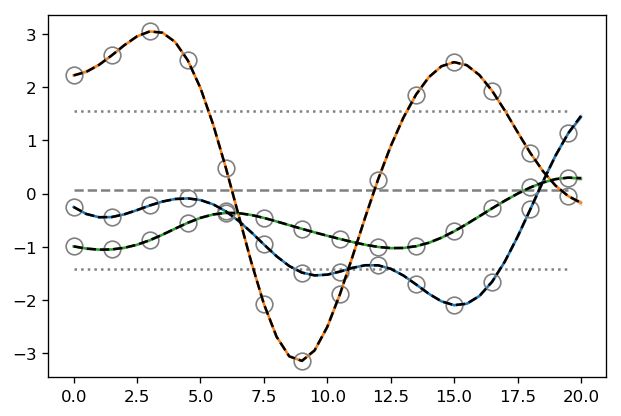

In [18]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
toy_data_pred = toy_data_full[:, ~mask]

#compute the mean and covariance of the fitted GP at the training-set points
fitmean = my_gp.mean()
fitcov = my_gp.cov()

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances
X_new = X_full
X_test = X_full[~mask]
m_pred, K_pred = my_gp.predict(X_new, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

#compute the mean and covaraince of the overall GP at the set X_full, note that a nugget should be added to fitcov_full when it is used below.
fitmean_full = my_gp.mean(X_new) 
fitcov_full = my_gp.cov(X_new,X_new) 

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_new.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_new.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

This time the standard deviation comes out a bit larger than one.

## Learning the length scale: medium-variance-shift case, different seed

Now we will do the length-scale learning for this medium-variance-shift case

In [19]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)

Setting kernel kwargs to {'ls': 3.027272727272728}


How will the diagnostics look?

Setting kernel kwargs to {'ls': 3.027272727272728}


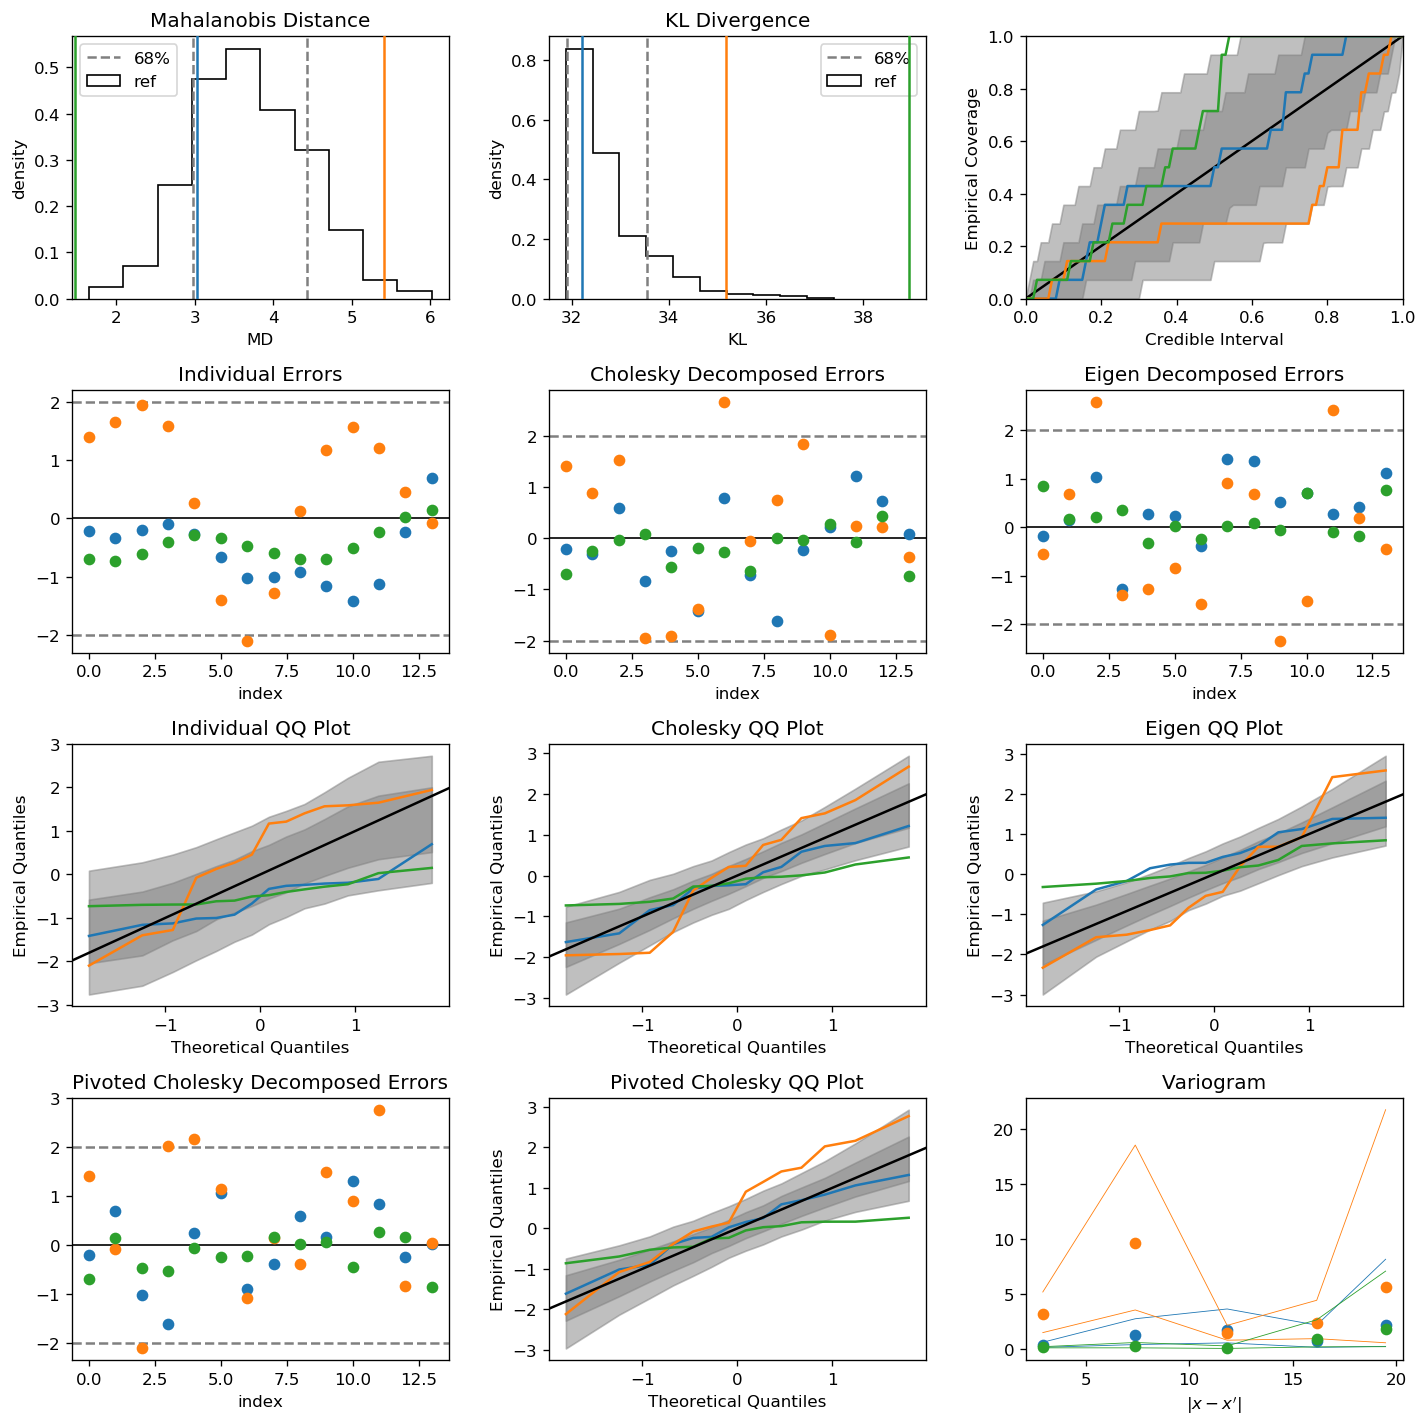

In [20]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()
fitmean_test=gp.mean(X_test)
fitcov_test=gp.cov(X_test,X_test)

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

These look more or less as expected. 

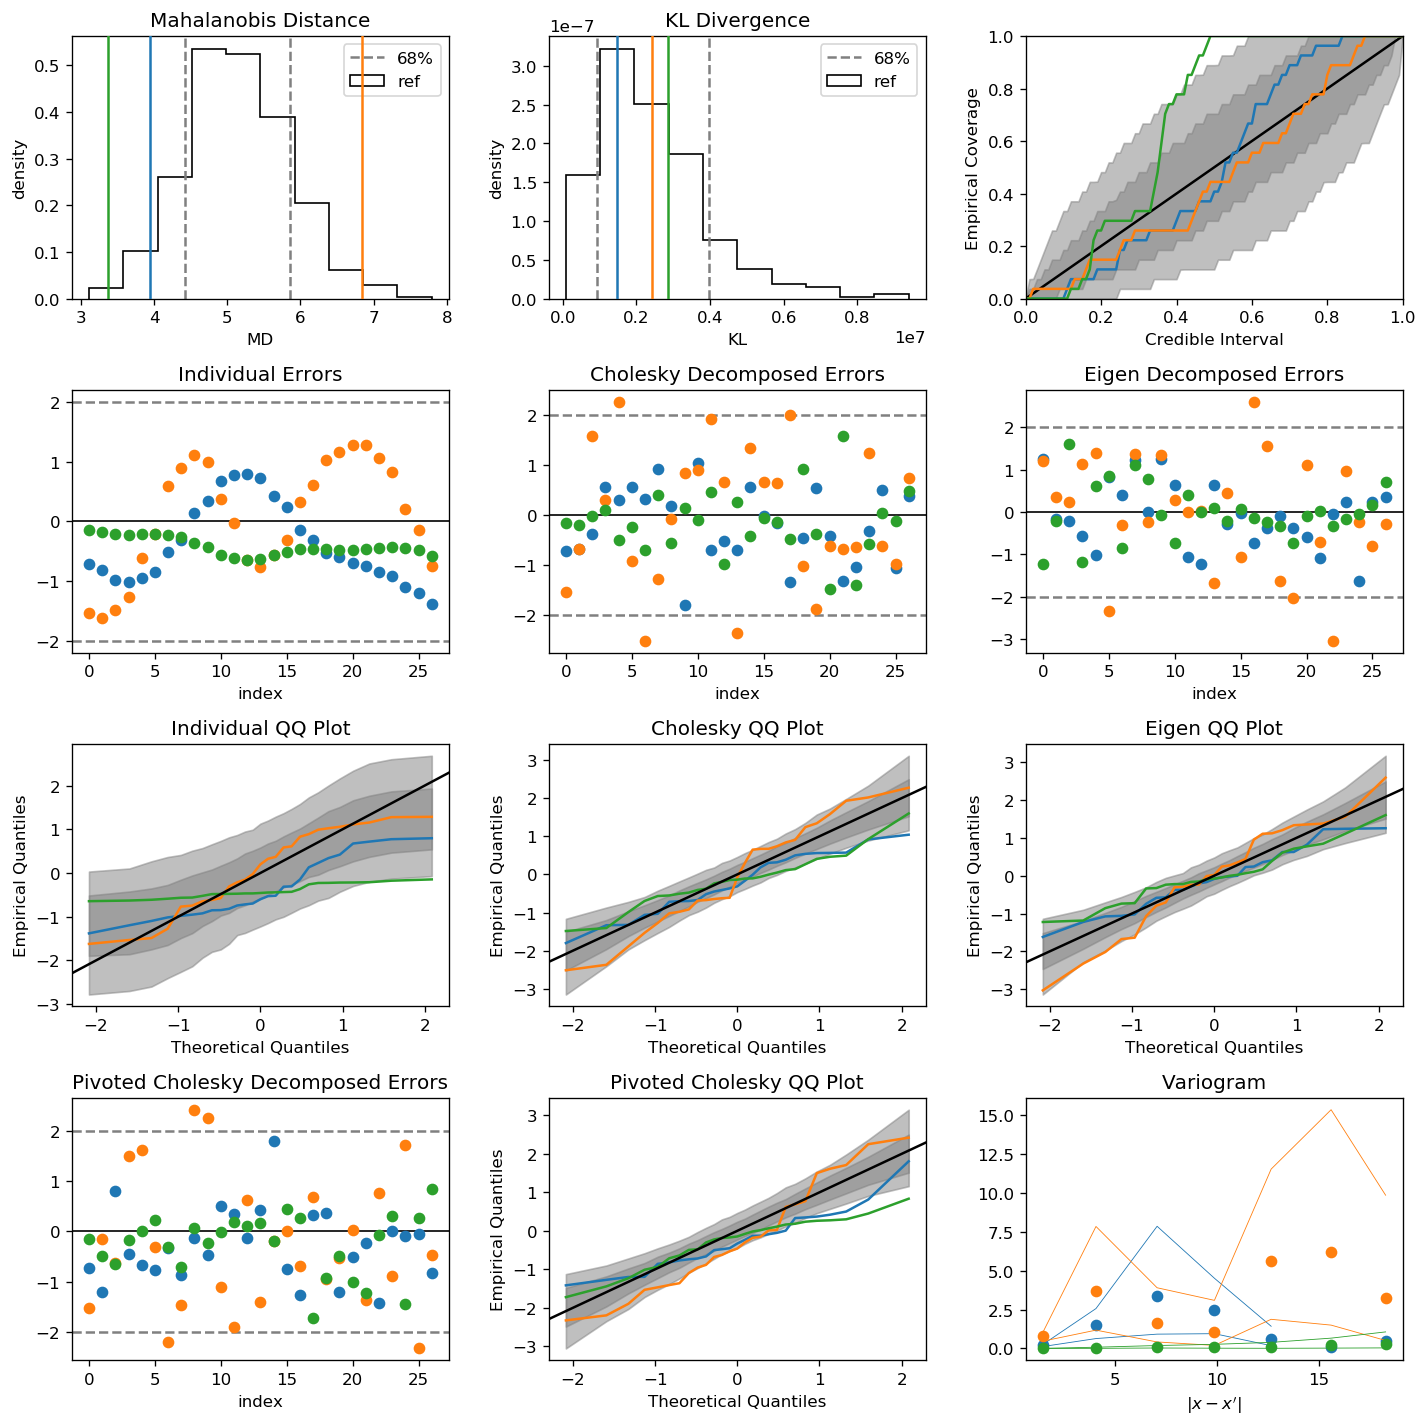

In [21]:
gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd_test = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd_test.plotzilla(X_test, gp_static, vlines=vlines);

These look reassuringly similar to results in old notebook where we a) did not estimate length scale and b) used full data set, not just test data. Quoting from there: "MD for orange curve is again too large. DCI plot does show problems for green though. Eigen decomposed errors again show structure: errors are too large (small) at high index for orange (green). Pivoted Cholesky errors from index 1-[13] show similar issues to eigen-errors at large index. PC QQ plot has orange errors "on the edge". It's noticeable there that the blue errors don't have the correct QQ-plot slope, and that shows up in the eigen-error QQ plot too."

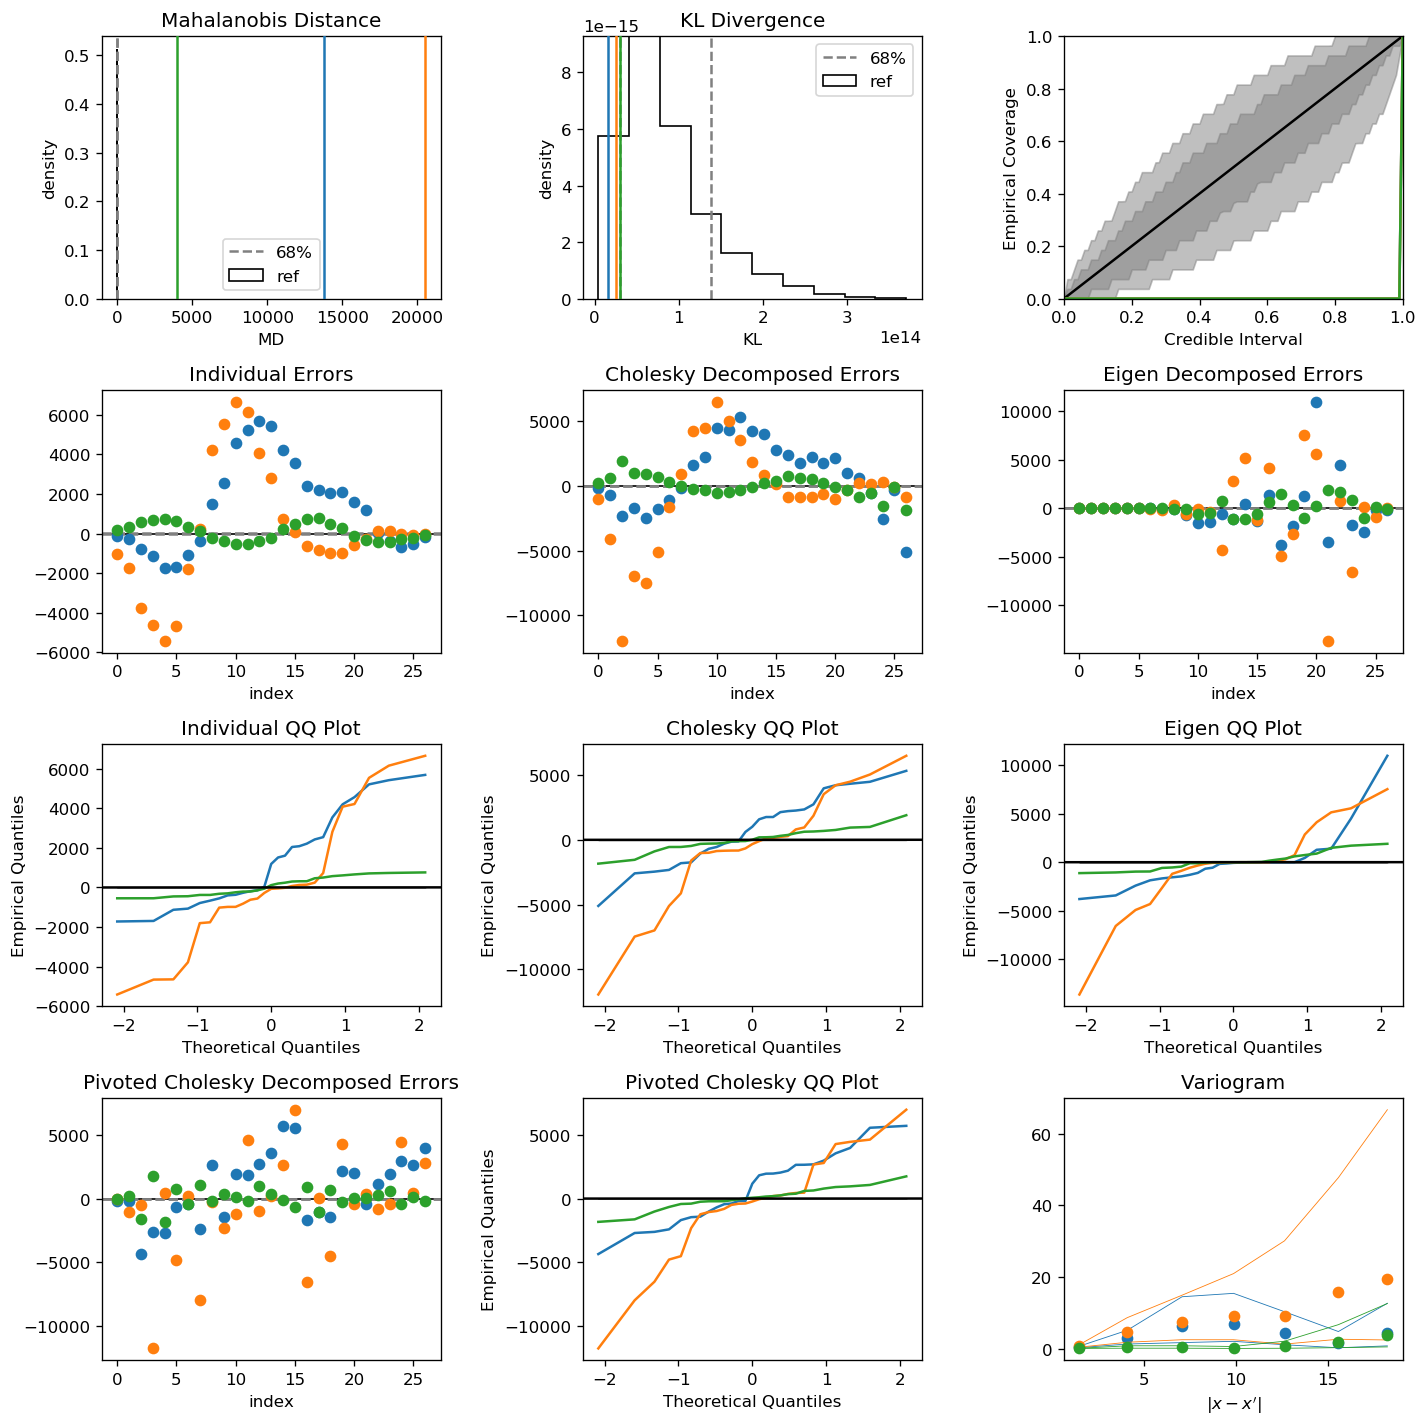

In [22]:
#ls_mesh = np.linspace(0.1, 7, 100)
#gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
#gp.fit(X, toy_data, noise_sd=nugget_sd)
#best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
#gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)

mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)

gpmc = Diagnostic(np.zeros(mean_test.shape[1]), cov_test + nugget_sd**2 * np.eye(cov_test.shape[0]))
gd = GraphicalDiagnostic(gpmc, toy_data_test-mean_test, nref=n_ref)
gd.plotzilla(X_test, gp_static, vlines=vlines);

Something very odd happens here. 

## Middle-sized variance shift, a third noise choice
Now we try with y.a. seed, to see what changes and what doesn't

In [23]:
basevariance=1.0; varianceshiftfactor=3; baselengthscale=3; lengthscaleshift=0

In [24]:
true_kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvarup_kernel=C(basevariance*varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvardown_kernel=C(basevariance/varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthup_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale+lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthdown_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale-lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

gp1 = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None,)
gp2 = GaussianProcessRegressor(kernel=shiftvarup_kernel,n_restarts_optimizer=9, optimizer=None)
gp3 = GaussianProcessRegressor(kernel=shiftvardown_kernel,n_restarts_optimizer=9, optimizer=None)

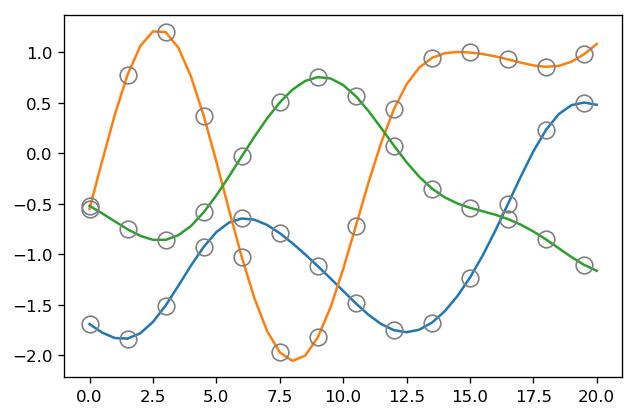

In [25]:
# Instantiate a Gaussian Process model

# gp.fit()
#toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
#mean_full, cov_full = gp.predict(X_full, return_cov=True)
#The above three lines of code get replaced by something a bit more complicated when we have different GPs that we want to lump together as if they were one.
#Note that we gave up returning the covariances of the GP for which we generate the data since we decided we should not be using them.
seed=3; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T
#Note also that I (DP) have switched the seed after each call, to try and get GPs that start at somewhat different points. This may be unnecessary? But I hope
#it is at least not wrong. :) 


mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

#mean = mean_full[mask]
#cov = cov_full[mask][:, mask]
#I comment out these two lines since I do not think we should be using these quantities: the code should interact with the underlying GP
#only through the toy_data, which we now generate.

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

toy_data = toy_data_full[:, mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Remember: blue curve is the original variance (1), orange has a larger variance, and green a smaller one. 

Once again, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

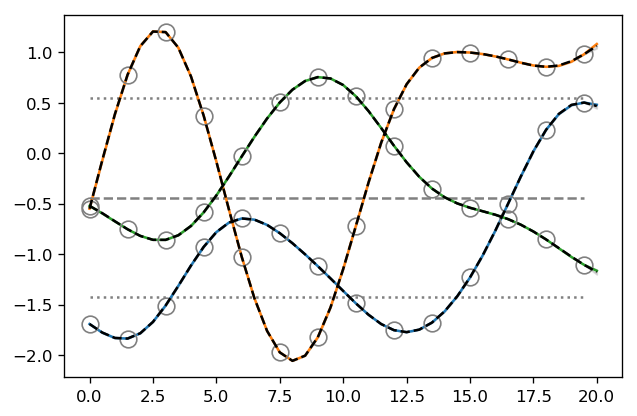

In [26]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
# X_new = X_full[~mask]
# toy_data_pred = toy_data_full[:, ~mask]

#compute the mean and covariance of the fitted GP at the training-set points
fitmean = my_gp.mean()
fitcov = my_gp.cov()

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances
X_new = X_full
m_pred, K_pred = my_gp.predict(X_new, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

#compute the mean and covaraince of the overall GP at the set X_full, note that a nugget should be added to fitcov_full when it is used below.
fitmean_full = my_gp.mean(X_new) 
fitcov_full = my_gp.cov(X_new,X_new) 

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_new.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_new.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

This time the standard deviation is okay but the mean is markedly different from zero. How will this show up in diagnostics?

## Learning the length scale: medium-variance-shift case, y.a. seed

Now we will do the length-scale learning for this third medium-variance-shift case

In [27]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)

Setting kernel kwargs to {'ls': 3.027272727272728}


How will the diagnostics look?

Setting kernel kwargs to {'ls': 3.027272727272728}


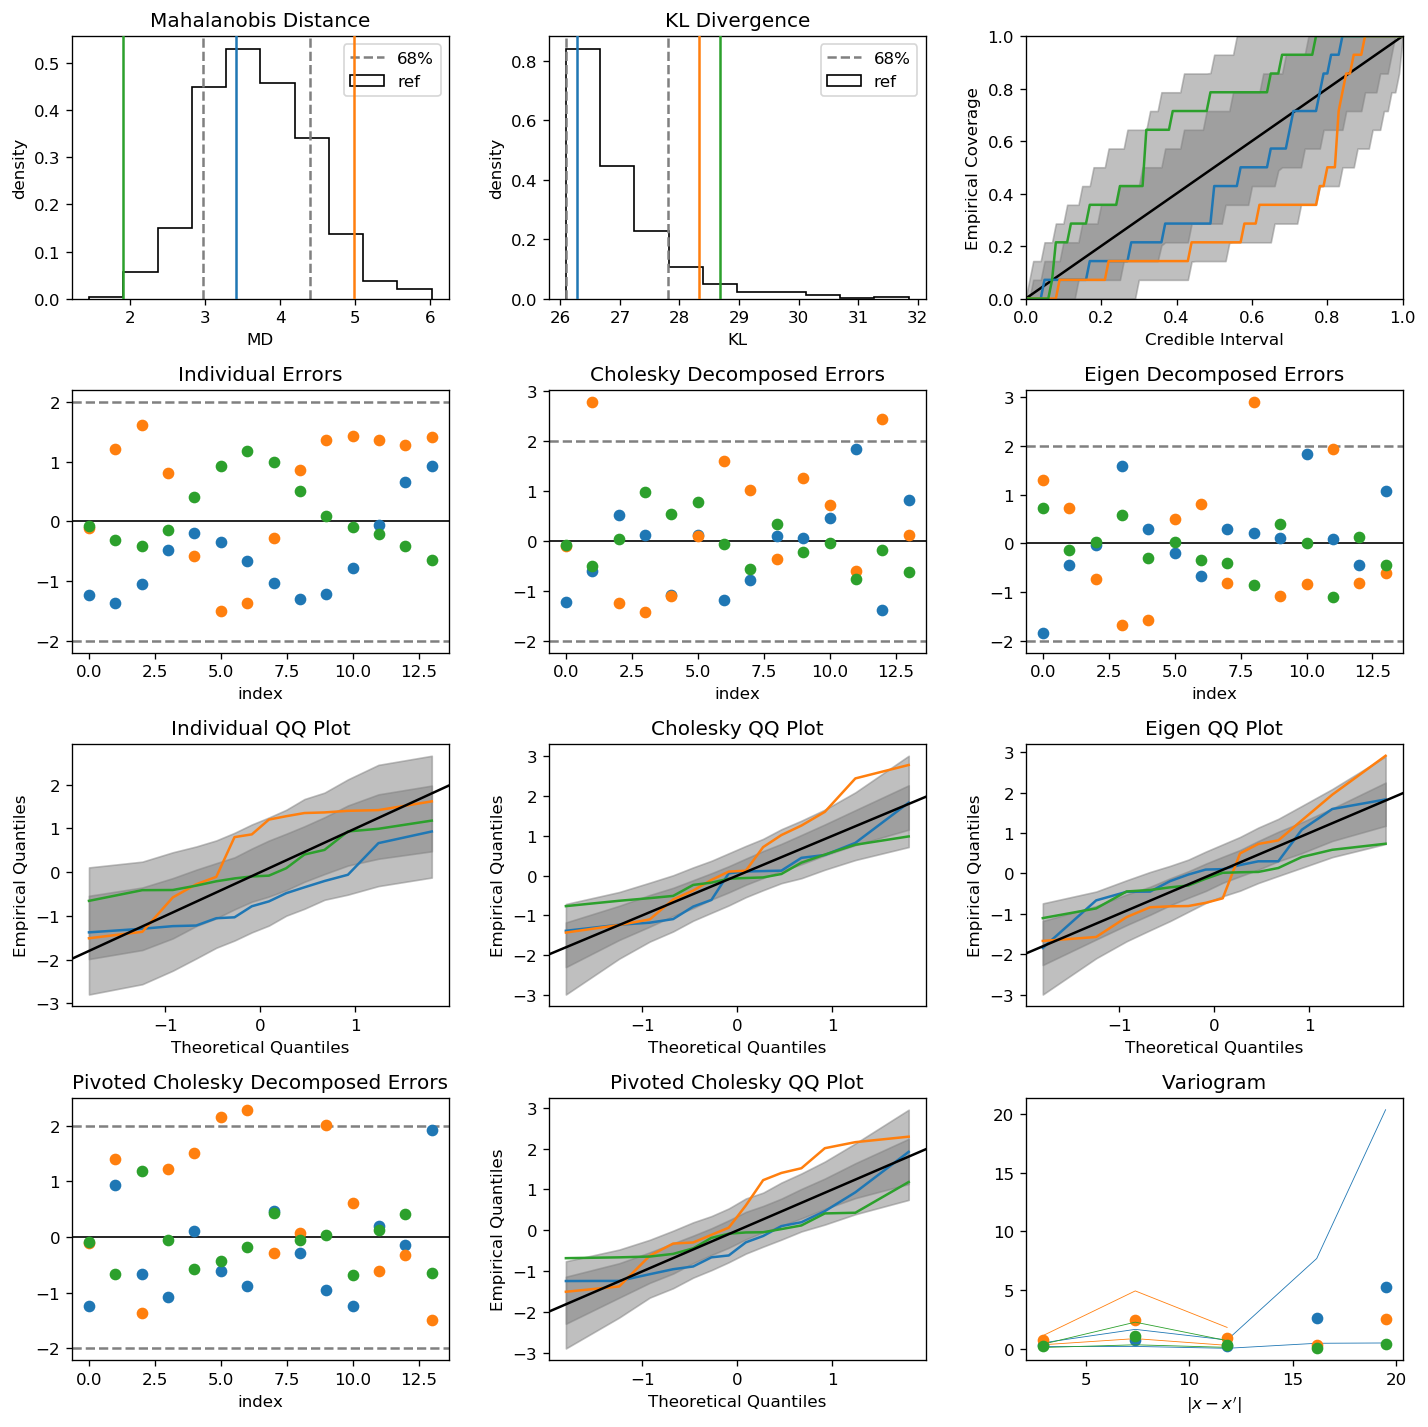

In [28]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()
mean_test=gp.mean(X_test)
cov_test=gp.cov(X_test,X_test)

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

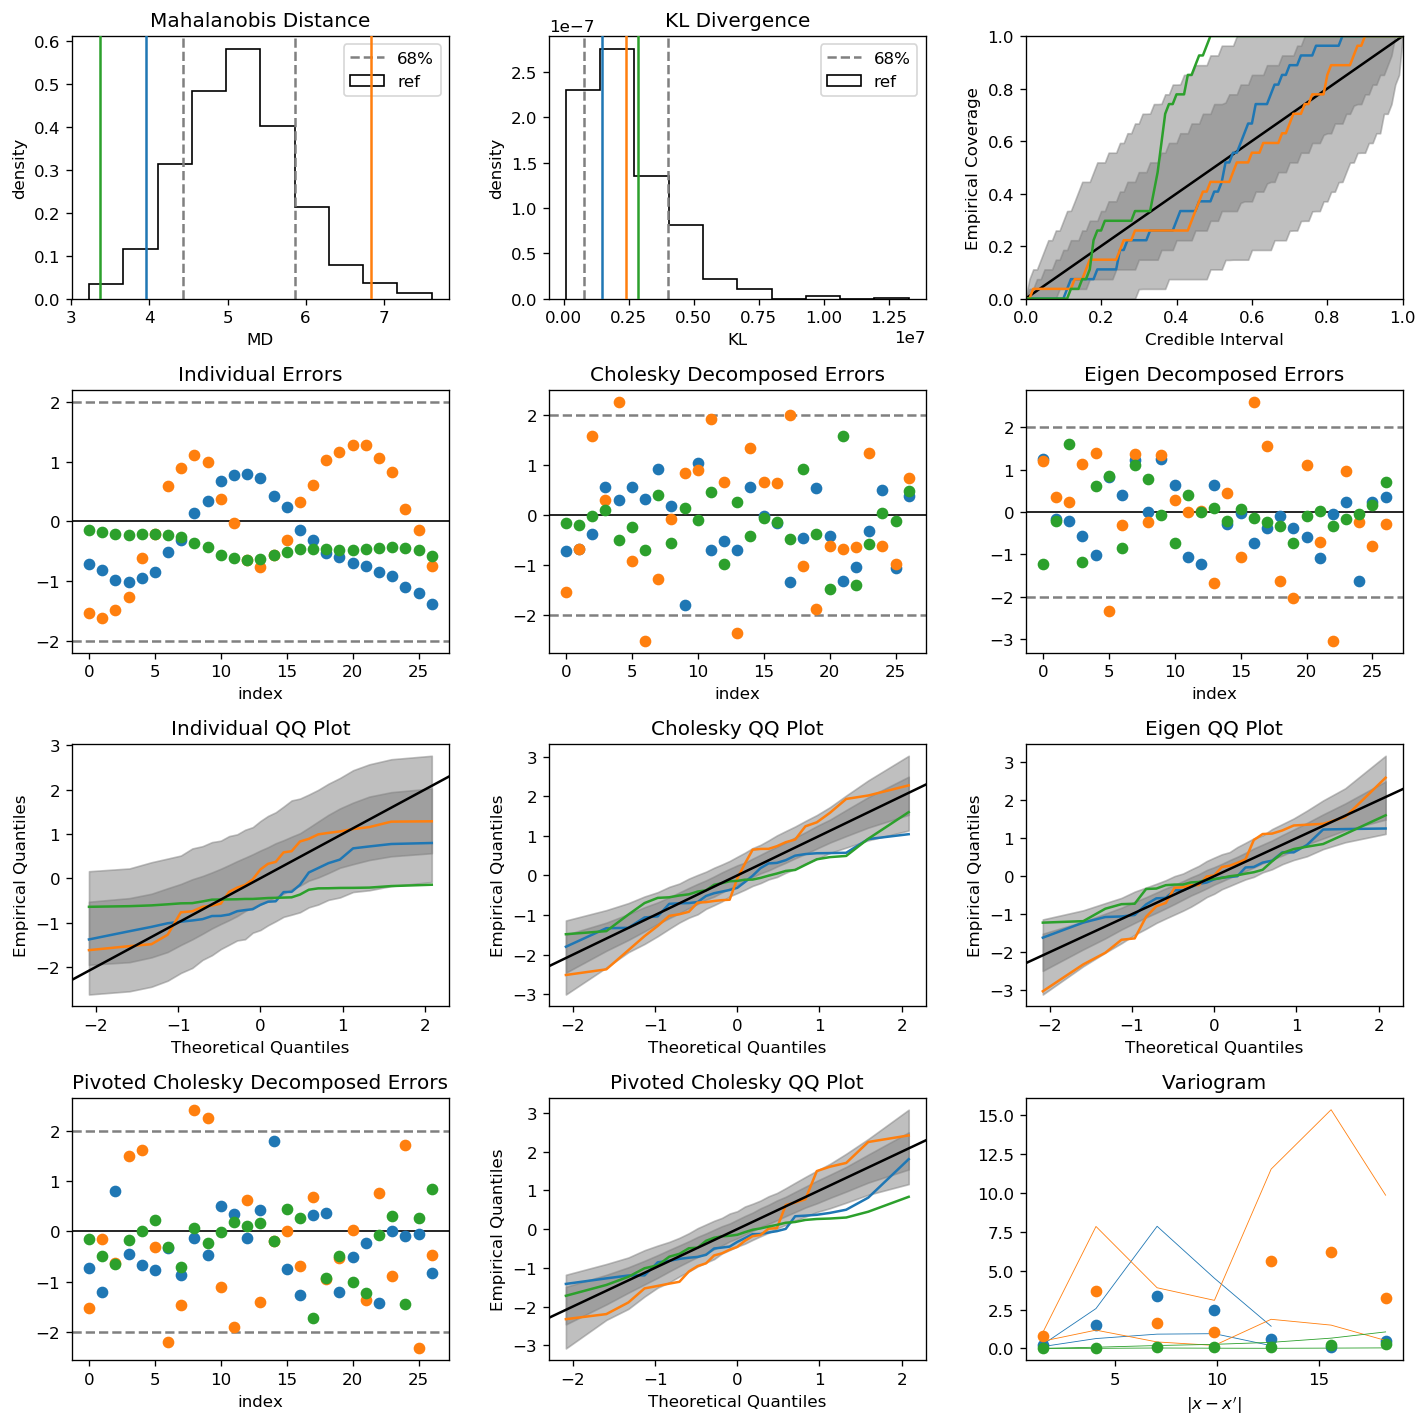

In [29]:
gpmc_test = Diagnostic(fitmean_test, fitcov_test + nugget_sd**2 * np.eye(fitcov_test.shape[0]))
gd_test = GraphicalDiagnostic(gpmc_test, toy_data_test, nref=n_ref)
gd_test.plotzilla(X_test, gp_static, vlines=vlines);

MD for orange curve is again too large, that for green is too small. DCI plot  shows problems for green. Eigen decomposed errors again show structure: errors are too large (small) at high index for orange (green). Pivoted Cholesky errors from index 1-20 show similar issues to eigen-errors at large index. PC QQ plot has too many orange errors that are too large, and too many green errors that are too small. Complementary to plot with index! The same issues show up in the eigen error QQ plot.

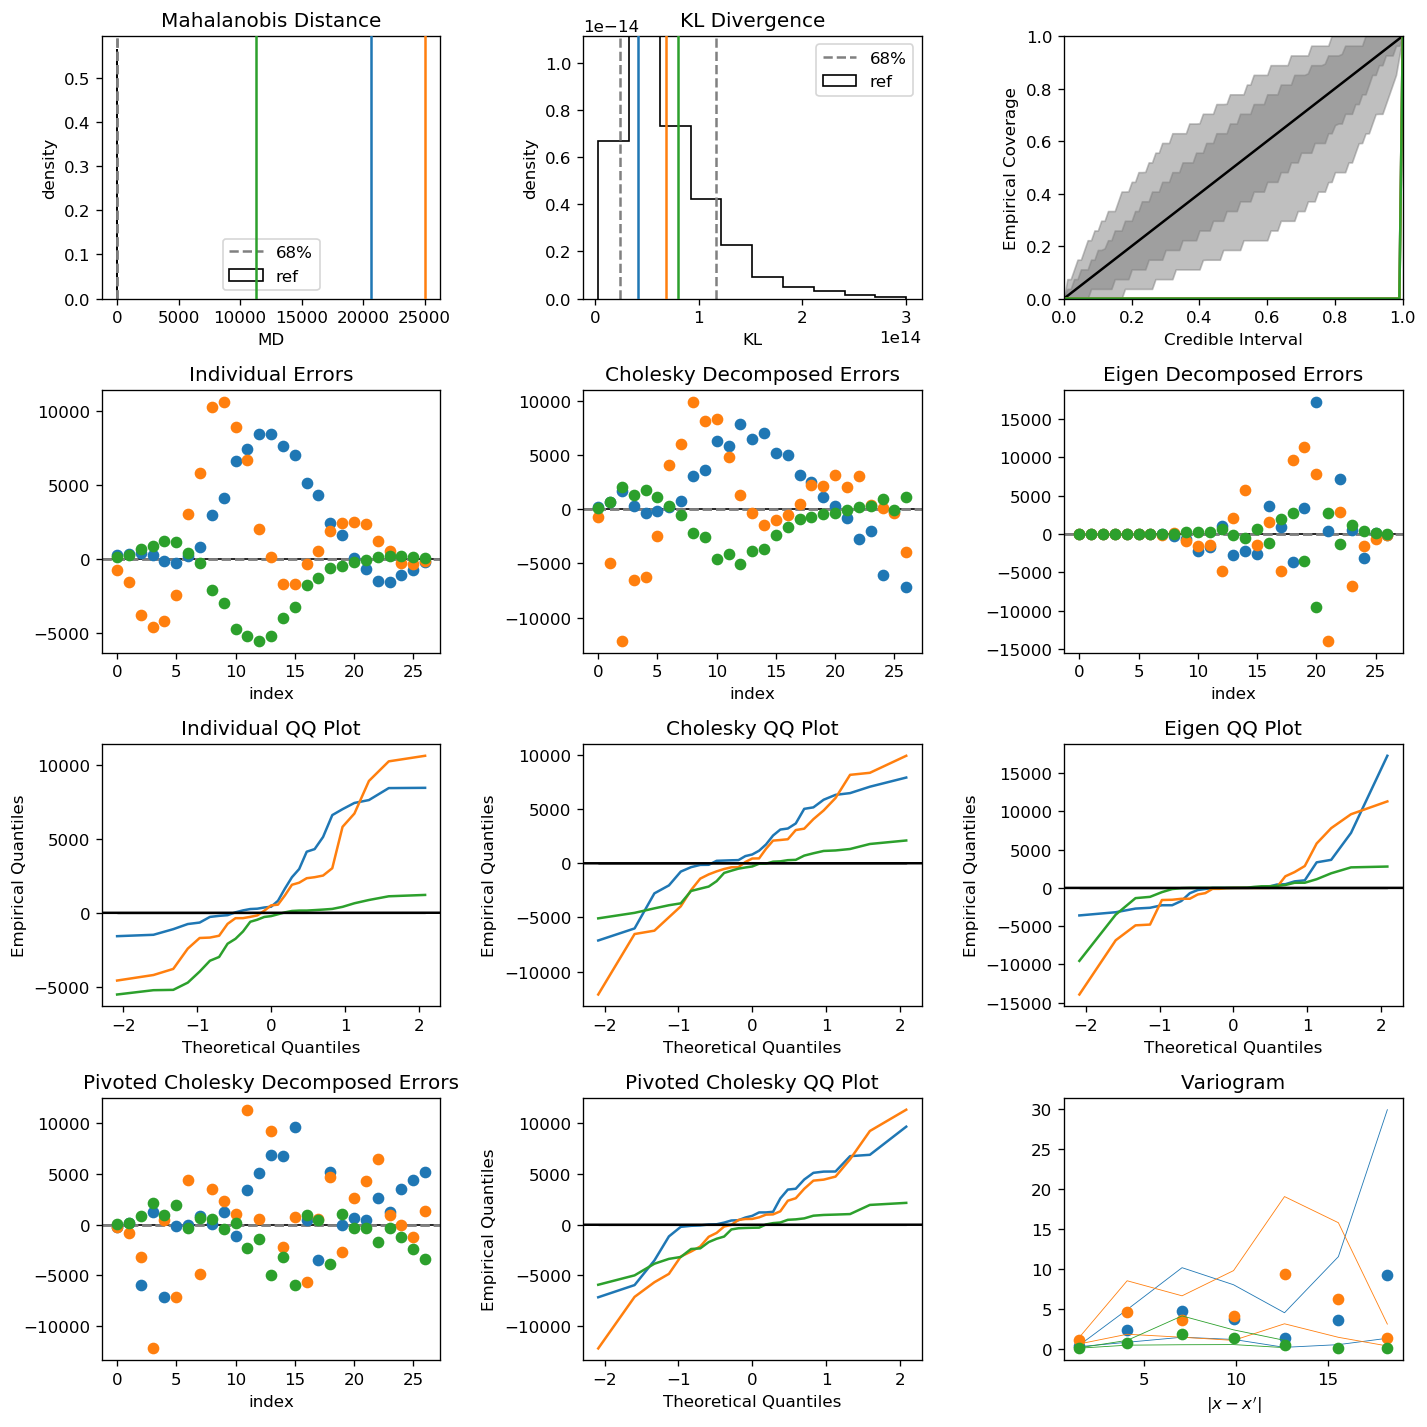

In [30]:
mean_test, cov_test = gp.predict(X_test, return_cov=True, pred_noise=True)

gpmc = Diagnostic(np.zeros(mean_test.shape[1]), cov_test)
gd = GraphicalDiagnostic(gpmc, toy_data_test-mean_test, nref=n_ref)
gd.plotzilla(X_test, gp_static, vlines=vlines);

There's something on around here. What it is ain't exactly clear. (At least to me....)